# Representation Analysis

In [8]:
import torch
import os

#@markdown Execute this cell to check the Colab environment, including GPU availability.

# check gpu env
print(f"Torch: {torch.__version__} \n" + 
      f"Availability: {torch.cuda.is_available()}")
assert torch.cuda.is_available() == True, "The GPU is turned off. To turn it on, navigate to: Runtime > Change Runtime Type."
print(f"Number: {torch.cuda.device_count()} \n" +
      f"Current device: {torch.cuda.current_device()} \n" +
      f"First device: {torch.cuda.device(0)} \n" +
      f"Device name: {torch.cuda.get_device_name(0)}")

Torch: 2.2.0+cu121 
Availability: True
Number: 1 
Current device: 0 
First device: <torch.cuda.device object at 0x7ff080552590> 
Device name: NVIDIA GeForce RTX 3090


In [9]:
import os
import math
import numpy as np
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import timm.data.transforms_factory as tff
from fastai.data.external import untar_data, URLs
from utils import subsample

#@markdown Execute this cell to download and import the *Imagenette* dataset, which is a small subset of ImageNet, for simplicity.

# use imagenette (a small subset of imagenet) as an example for simplicity
imagenet_path = untar_data(URLs.IMAGENETTE_160)

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

transform_test = tff.transforms_imagenet_eval(
    img_size=192, mean=imagenet_mean, std=imagenet_std,
)

test_dir = os.path.join(imagenet_path, 'val')
dataset_test = datasets.ImageFolder(test_dir, transform_test)
dataset_test = torch.utils.data.Subset(
    dataset_test, 
    subsample(dataset_test, ratio=math.pow(2,-6))  # use a subsampled batch
)

dataset_test = DataLoader(
    dataset_test, 
    num_workers=1, 
    batch_size=16,
)

## Load the Models

In [10]:
# wSimMIM
import torch
from configs.config import parameters_base as parameters
import transformers

T = 0.25
w_ps = 8

DIMENSION = parameters['dimension']                                 # dimension of image
MODEL_PATCH_SIZE = parameters['model_patch_size']                   # patch size         
MASKING_PATCH_SIZE = parameters['masking_patch_size']               # masking patch size
MASK_RATIO = parameters['mask_ratio']                               # model masking ratio
INTERMEDIATE_SIZE = parameters['intermediate_size']                      # model patch size to conform with VIT specs

# model config
HIDDEN_SIZE = parameters['hidden_size']
HIDDEN_LAYERS = parameters['num_hidden_layer']
ATTN_HEADS = parameters['num_attention_heads']

config = transformers.ViTConfig(
    hidden_size = HIDDEN_SIZE,
    num_hidden_layers = HIDDEN_LAYERS,
    num_attention_heads= ATTN_HEADS,
    image_size = DIMENSION,
    patch_size = MODEL_PATCH_SIZE,
    intermediate_size= INTERMEDIATE_SIZE,
    num_channels= 3,
)

model = transformers.ViTForMaskedImageModeling(config)
model = model.cuda()
model = model.eval()

state_dict = torch.load(f'weights/ViT-B/wSimMIM [weight_ps = {w_ps}] [T = {T}]/checkpoint_final.pth')
_ = model.load_state_dict(state_dict, strict=False)
model_wsimmim = model.vit

In [11]:
# SimMIM
import torch
from configs.config import parameters_base as parameters
import transformers

DIMENSION = parameters['dimension']                                 # dimension of image
MODEL_PATCH_SIZE = parameters['model_patch_size']                   # patch size         
MASKING_PATCH_SIZE = parameters['masking_patch_size']               # masking patch size
MASK_RATIO = parameters['mask_ratio']                               # model masking ratio
INTERMEDIATE_SIZE = parameters['intermediate_size']                      # model patch size to conform with VIT specs

# model config
HIDDEN_SIZE = parameters['hidden_size']
HIDDEN_LAYERS = parameters['num_hidden_layer']
ATTN_HEADS = parameters['num_attention_heads']

config = transformers.ViTConfig(
    hidden_size = HIDDEN_SIZE,
    num_hidden_layers = HIDDEN_LAYERS,
    num_attention_heads= ATTN_HEADS,
    image_size = DIMENSION,
    patch_size = MODEL_PATCH_SIZE,
    intermediate_size= INTERMEDIATE_SIZE,
    num_channels= 3,
)

model = transformers.ViTForMaskedImageModeling(config)
model = model.cuda()
model = model.eval()

state_dict = torch.load('weights/ViT-B/SimMIM/checkpoint_final.pth')
_ = model.load_state_dict(state_dict, strict=False)
model_simmim = model.vit

## Fourier Analysis

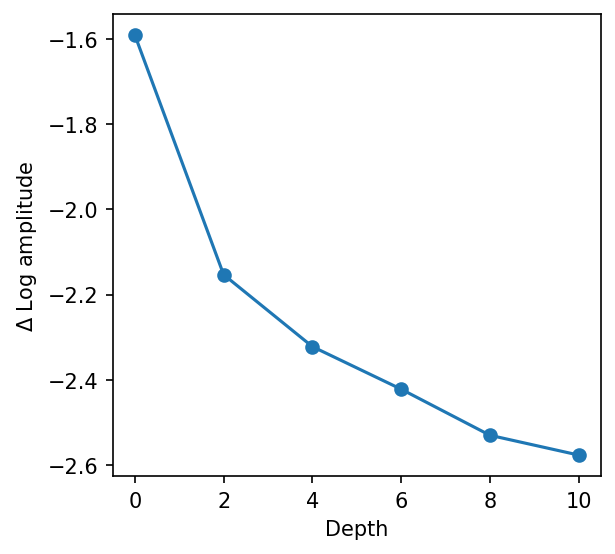

In [12]:
# build off the implementation of https://github.com/xxxnell/how-do-vits-work
import matplotlib.pyplot as plt
from einops import rearrange, reduce, repeat
from timm.utils import AverageMeter

def fourier(x):
    """2D Fourier transform"""
    f = torch.fft.fft2(x)
    f = f.abs() + 1e-6
    f = f.log()
    return f

def shift(x):  
    """shift Fourier transformed feature map"""
    b, c, h, w = x.shape
    return torch.roll(x, shifts=(int(h/2), int(w/2)), dims=(2, 3))

def get_fourier_latents(latents):
    """Fourier transform feature maps"""
    fourier_latents = []
    for latent in latents:  # `latents` is a list of hidden feature maps in latent spaces
        latent = latent.cpu()
        b, n, c = latent.shape
        h, w = int(math.sqrt(n)), int(math.sqrt(n))
        latent = rearrange(latent, "b (h w) c -> b c h w", h=h, w=w)
        
        latent = fourier(latent)
        latent = shift(latent).mean(dim=(0, 1))
        latent = latent.diag()[int(h/2):]  # only use the half-diagonal components
        latent = latent - latent[0]  # visualize 'relative' log amplitudes 
                                     # (i.e., low-freq amp - high freq amp)
        fourier_latents.append(latent)

    return fourier_latents
    
#@markdown Execute this cell to conduct Fourier analysis. The y-axis shows the amplitude (magnitude) of the high-frequency information. 
#@markdown 
#@markdown The results show that CL (MoCo) mainly exploits low-frequency information whereas MIM (SimMIM) exploits high-frequency information.

model_option = "wsimmim"  #@param ["wsimmim", "simmim"]
if model_option == "wsimmim":
    model = model_wsimmim
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

fourier_latents = AverageMeter()
for i, (xs, ys) in enumerate(dataset_test):
    with torch.no_grad():
        xs = xs.cuda()
        zs = model(xs, output_hidden_states = True)['hidden_states']
        zs = zs[:-1]

    latents = [z[:,1:,:] for z in zs]
    _fourier_latents = torch.stack(get_fourier_latents(latents))
    fourier_latents.update(_fourier_latents)

    if i > -1:
        break
        
fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
fourier_latents = fourier_latents.avg
ax.plot(range(0, 12, 2), fourier_latents[:,-1][::2], marker="o")
ax.set_xlabel("Depth")
ax.set_ylabel("$\Delta$ Log amplitude")
# ax.set_ylim(top=-1.5, bottom=-3.5)

save_path = f'figures/{model_option}/'
os.makedirs(save_path, exist_ok=True, mode = 511)
plt.savefig(save_path + 'fourier_analysis.png', facecolor = 'white')

## Toekn-level t-SNE Visualization

In [13]:
with torch.no_grad():
    xs = xs.cuda()
    zs = model(xs, output_hidden_states = True, output_attentions = True)

/home/ml/miniconda3/envs/representation_analysis/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


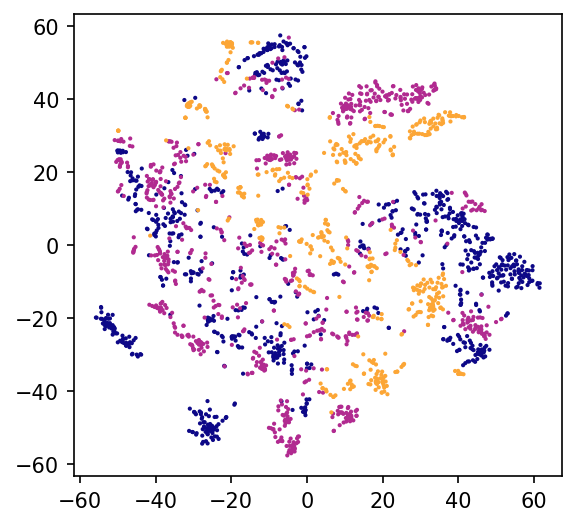

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from sklearn.manifold import TSNE
from einops import rearrange, reduce, repeat

def visualize_token_tsne(ax, zs, depth, ys, cmap=matplotlib.colormaps["plasma"]): 
    latents = zs[depth]
    latents = latents[:,1:,:]  # drop cls
    latents = rearrange(latents, "b n c -> (b n) c",)
    latents = latents.cpu()
    
    reducer = TSNE(n_components=2, perplexity=20, learning_rate='auto', init='random', n_iter=1000)
    embedded = reducer.fit_transform(latents)
    
    labels = ys 
    labels = np.array([[label] * 144 for label in labels]).flatten()
    c = [cmap(label / (max(labels) + 0.5)) for label in labels]
    
    ax.scatter(embedded[:,0], embedded[:,1], c=c, s=1)
    
#@markdown Execute this cell to visualize token-level representations by using t-SNE. Note that we visualize 3,528 tokens (196 tokens×18 images) from the representations. 
#@markdown 
#@markdown The tokens of MoCo form a cluster for each image, while those of SimMIM are intermingled. This aligns with the finding that, compared to SimMIM, MoCo is linearly separable. The colors represent three different classes.

depth = 10  #@param {type:"slider", min:0, max:11, step:1}
if model_option == "wsimmim":
    model = model_wsimmim
elif model_option == "simmim":
    model = model_simmim
else:
    raise Exception("Invalid option: ", model_option)

xs, ys = next(iter(dataset_test))
with torch.no_grad():
    xs = xs.cuda()
    zs = model(xs, output_hidden_states = True)['hidden_states']
    zs = zs[:-1]

fig, ax = plt.subplots(1, 1, figsize=(4.2, 4), dpi=150)
visualize_token_tsne(ax, zs, depth=depth, ys=ys)  # coloring at the image level

plt.savefig(save_path + 'token_level_tsne.png', facecolor = 'white')